In [18]:
# !pip install xgboost

In [2]:
# Import
import sys
import os

sys.path.append(os.path.abspath("../src"))
from preprocessing import preprocess_dior
from modelisation import (
    split_data,
    plot_train_test_split,
    transform_target,
    plot_target_transformation,
    ohe_encoding,
    count_encoding,
    target_encoding,
    train_model
)
from evaluate import(
    evaluate_model,
    plot_actual_vs_predicted,
    plot_residuals_distribution,
    plot_residuals_vs_predicted,
    plot_learning_curve,
    plot_correlation_matrix,
    plot_prediction_curve
)
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from load_data import load_dior
# chargement du dataset
df = load_dior()

C:\Users\poowd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X, y = preprocess_dior(df)

# X -> title + categories
# y -> price et price_eur

In [4]:
X.head()

,category1_code,category2_code,category3_code
0,WOMEN,SMALL LEATHER GOODS,MINI BAGS
1,WOMEN,SMALL LEATHER GOODS,POUCHES
2,WOMEN,MAISON,DECORATIVE PIECES
3,WOMEN,HANDBAGS,HANDBAGS
4,TIMEPIECES,EXCEPTIONAL TIMEPIECES,DIOR GRANDBAL


In [5]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2)

Shape X_train : (3580, 3)
Shape X_test  : (896, 3)
Shape y_train : (3580, 1)
Shape y_test  : (896, 1)


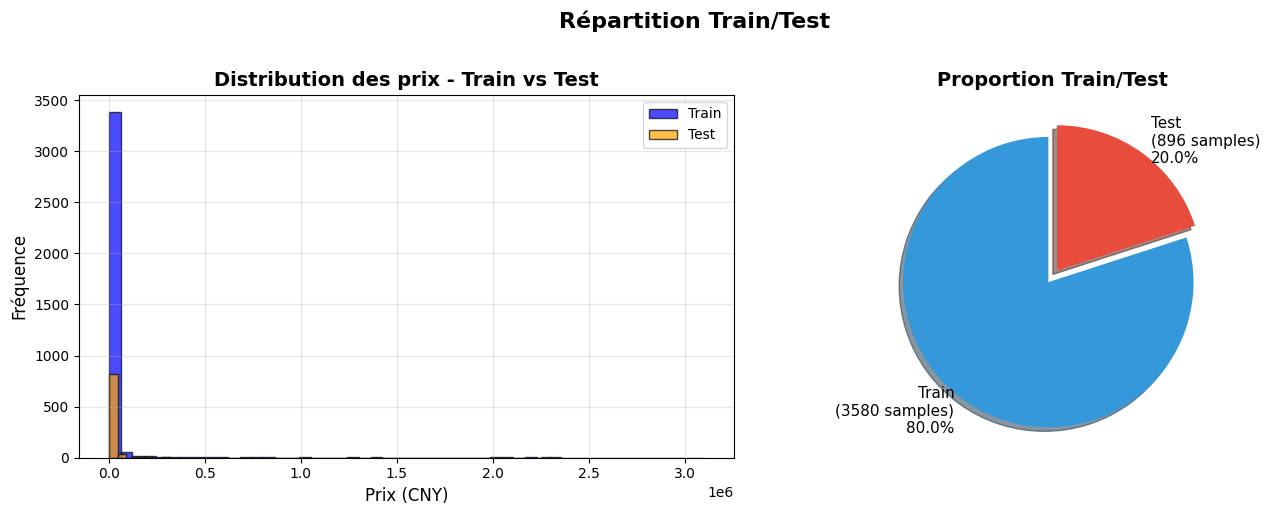

In [6]:
plot_train_test_split(y_train, y_test)

### Standardisation, Normalisation, Log

In [7]:
y_train_transformed, y_test_transformed, transform_info = transform_target(
    y_train, 
    y_test, 
    method='log'
)

Transformation: log(1 + prix)


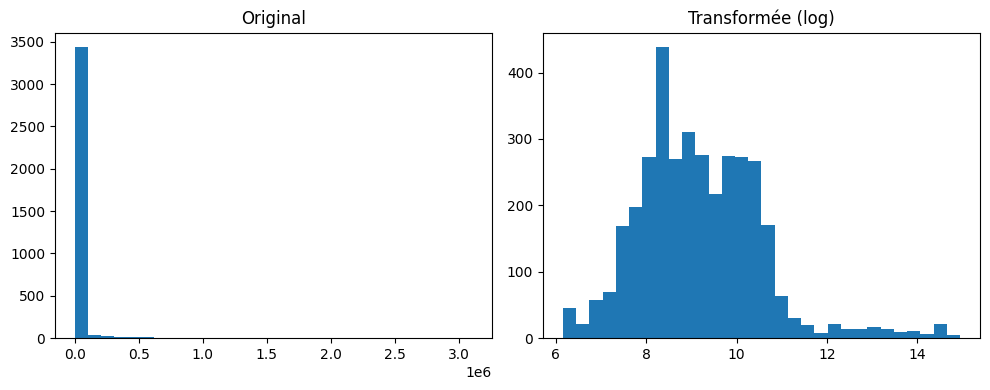

,price
2032,11.884496
4287,10.373522
1790,7.741099
1196,9.711176
696,8.594339
...,...
4448,8.716208
469,7.741099
3109,9.928229
3792,8.556606


In [8]:
plot_target_transformation(y_train, 'log')


### Encodage et transformation

In [9]:
X_train_encoder, X_test_encoder, enc2 = count_encoding(X_train, X_test, "category1_code")

In [10]:
X_train_encoder, X_test_encoder, enc2 = count_encoding(X_train_encoder, X_test_encoder, "category2_code")

In [11]:
X_train_encoder, X_test_encoder, enc2 = count_encoding(X_train_encoder, X_test_encoder, "category3_code")

In [12]:
print(X_train_encoder.columns[:20])

Index(['category1_code_count', 'category2_code_count', 'category3_code_count'], dtype='object')


In [13]:
print(X_train_encoder.shape)
print(X_test_encoder.shape)

(3580, 3)
(896, 3)


### Entrainement, Test, Prediction

**Choix du modèle : XGBoost**

Pour prédire le prix des produits Dior China, nous avons choisi **XGBoost Regressor**.  
Ce modèle est basé sur le **gradient boosting**, c’est-à-dire un ensemble d’arbres de décision construits **séquentiellement**, où chaque nouvel arbre corrige les erreurs des arbres précédents. Il capture ainsi des relations complexes entre les caractéristiques et le prix, gère les variables catégorielles encodées et reste robuste aux outliers. La prédiction finale est obtenue en combinant toutes les prédictions pondérées des arbres.

$$
\hat{y} = \sum_{m=1}^{M} \eta \, f_m(x)
$$

où :  
- $\hat{y}$ : valeur prédite par le modèle  
- $M$ : nombre total d’arbres  
- $f_m(x)$ : prédiction de l’arbre $m$ pour l’échantillon $x$  
- $\eta$ : taux d’apprentissage (learning rate) qui contrôle la contribution de chaque arbre

XGBoost réduit à la fois le **biais et la variance**, permet de gérer efficacement les interactions complexes entre variables et fournit des mesures d’importance des features pour interpréter le modèle.


In [19]:
#Modelisation avec XGBoost
from xgboost import XGBRegressor

In [21]:
model_LR = XGBRegressor()

# Training 
model_LR_trained = train_model(
    model_LR, 
    X_train_encoder, 
    y_train_transformed, 
    X_test_encoder, 
    y_test_transformed
)

In [22]:
# Prédictions sur le train
y_train_pred_log = model_LR_trained.predict(X_train_encoder)

# Inverse log transform
y_train_pred = np.expm1(y_train_pred_log)

# Calcul des métriques
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("TRAIN RMSE :", rmse_train)
print("TRAIN MAE  :", mae_train)
print("TRAIN R²   :", r2_train)

TRAIN RMSE : 91531.41187592378
TRAIN MAE  : 18231.72265625
TRAIN R²   : 0.8162225484848022


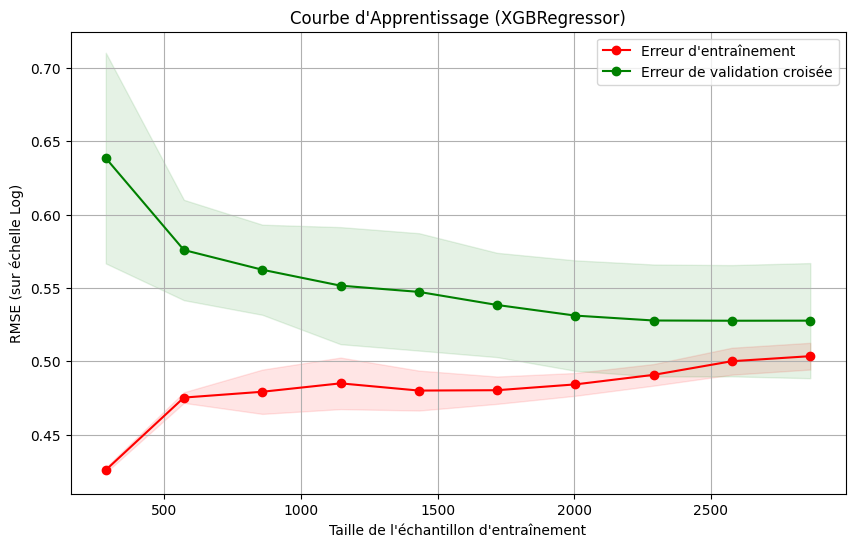

In [23]:
plot_learning_curve(model_LR, X_train_encoder, y_train_transformed)

In [24]:
evaluation_results = evaluate_model(
    model=model_LR_trained,
    X_test_encoder=X_test_encoder,
    y_test_raw=y_test  
)

print("\n Résumé des Performances")
print(f"Modèle : {evaluation_results['model_name']}")
print(f"RMSE : {evaluation_results['rmse']:,.2f}")
print(f"MAE  : {evaluation_results['mae']:,.2f}")
print(f"R²   : {evaluation_results['r2']:.4f}")


 Résumé des Performances
Modèle : XGBRegressor
RMSE : 90,653.85
MAE  : 18,190.06
R²   : 0.7992


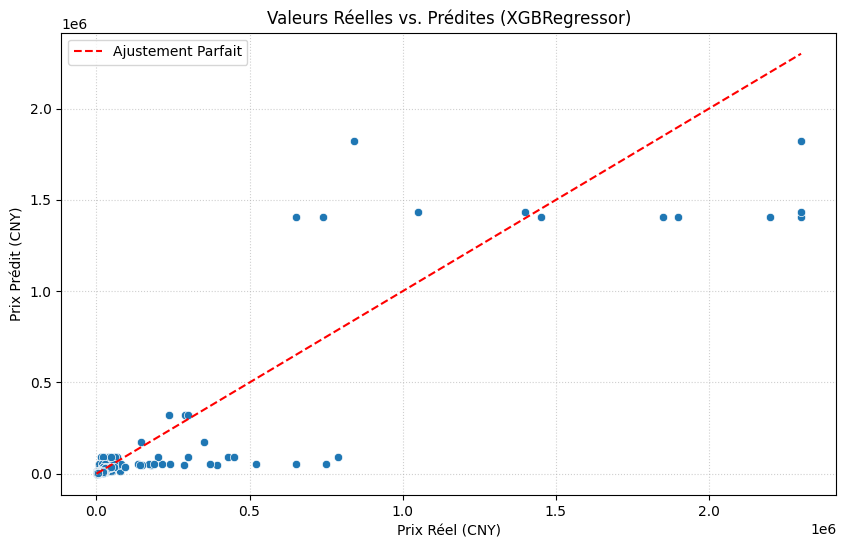

In [25]:
plot_actual_vs_predicted(y_test, evaluation_results['y_pred_original'], evaluation_results['model_name'])

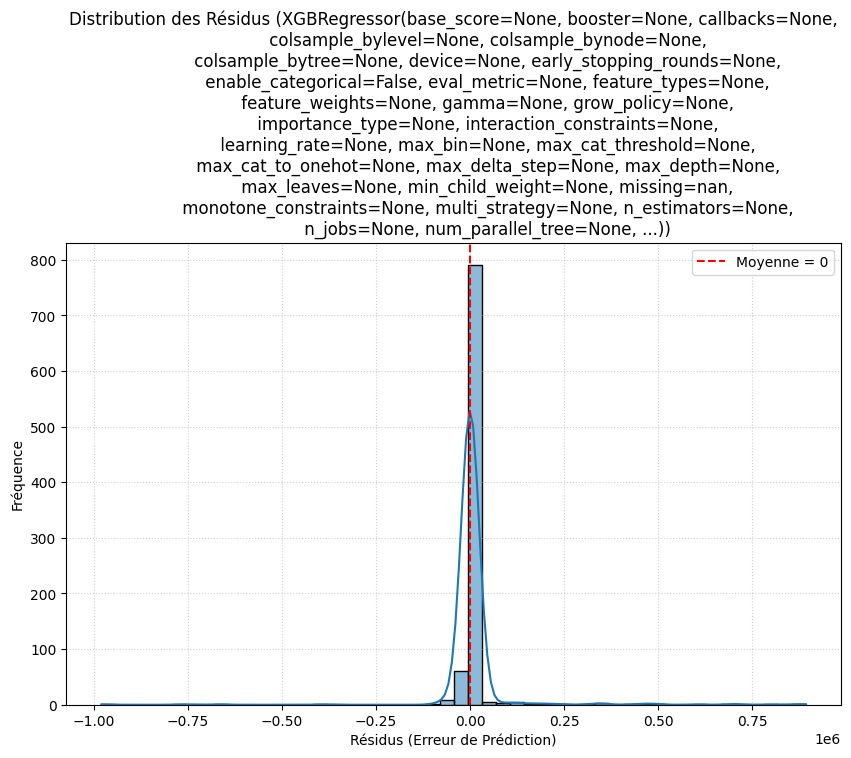

In [26]:
plot_residuals_distribution(y_test, evaluation_results['y_pred_original'], model_LR_trained)

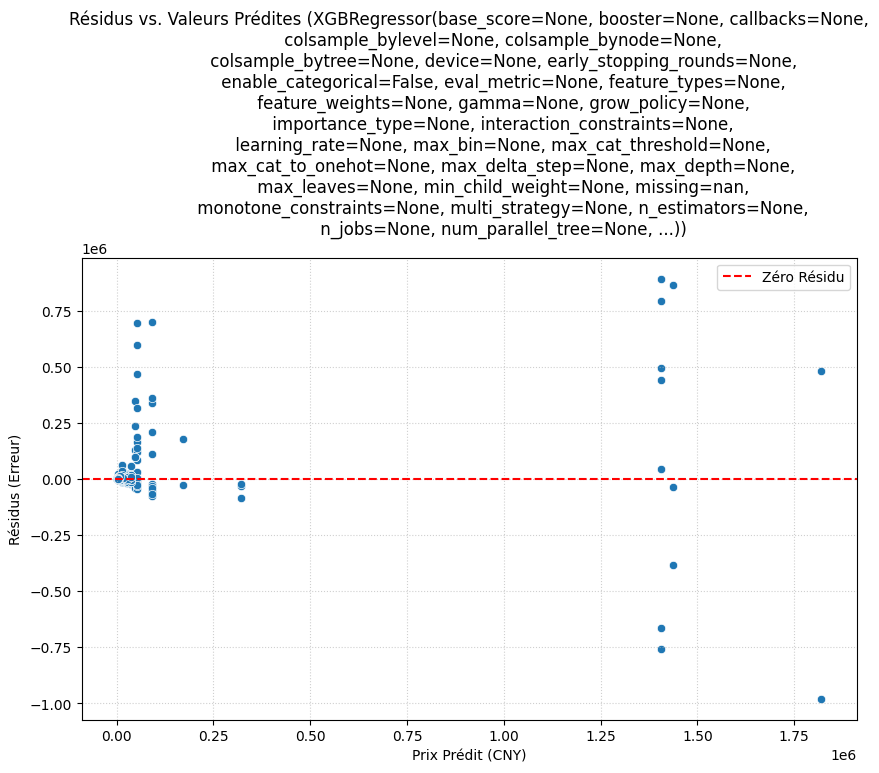

In [27]:
plot_residuals_vs_predicted(evaluation_results['y_pred_original'], y_test, model_LR_trained)

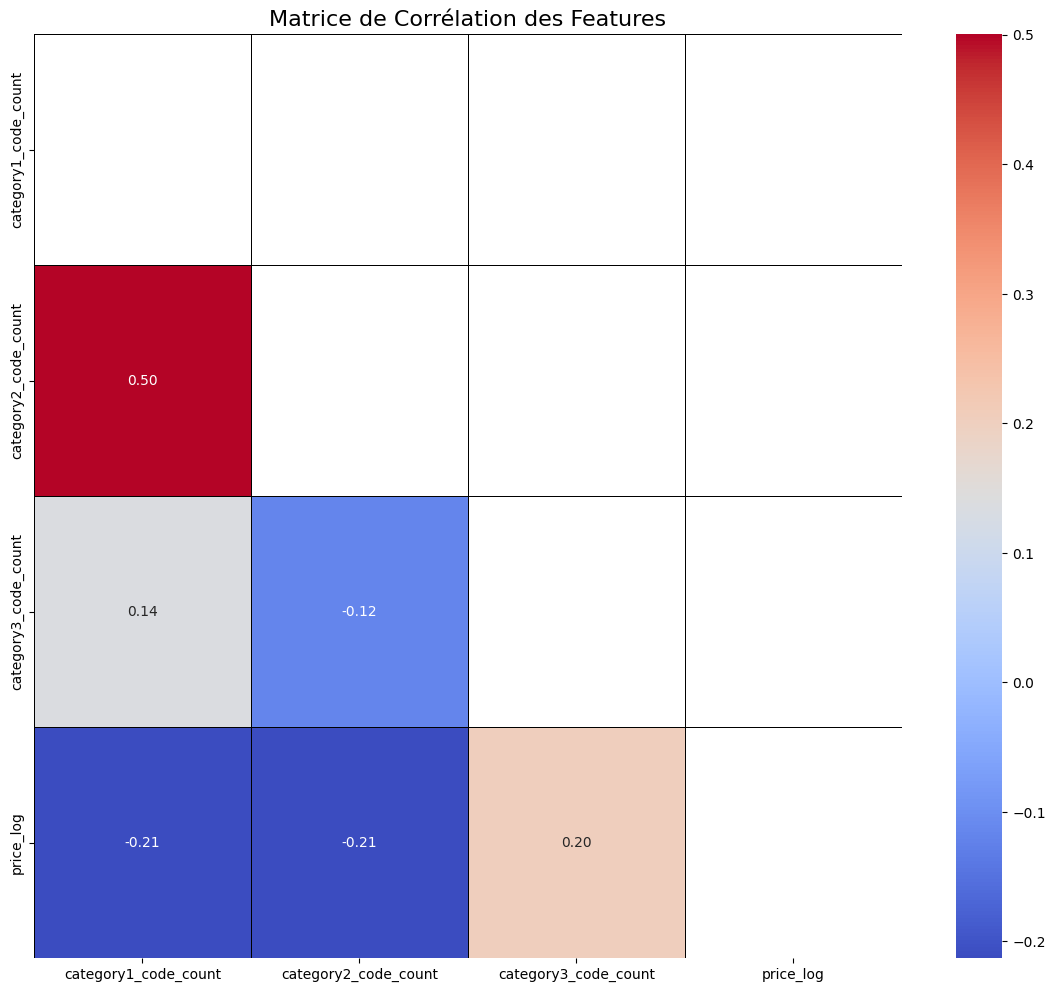

In [28]:
plot_correlation_matrix(X_train_encoder, y_train_transformed)

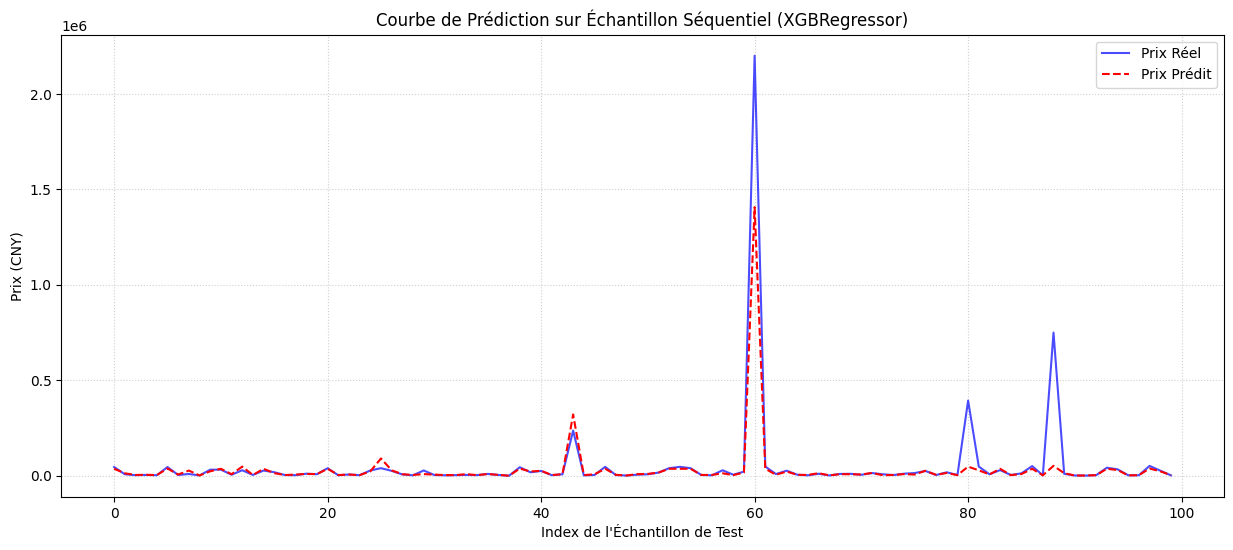

In [29]:
plot_prediction_curve(y_test, evaluation_results["y_pred_original"], evaluation_results["model_name"], sample_size=100)